# 66ers Feature Selection
* StellarAlgo Data Science
* Ryan Kazmerik & Nakisa Rad
* October 28, 2021

## Hypothesis
Write about the hunch you have and why you're running this experiment.

## Experiment
Document the experiment including selecting data, data transformations, feature engineering and modelling

In [1]:
import getpass
import pyodbc
import pandas as pd
import warnings
from pycaret.classification import *
from ngboost import NGBClassifier

warnings.filterwarnings('ignore')

### Let's connect to MSSQL and run a stored proc to get our dataset:

In [2]:
SERVER = '34.206.73.189' 
DATABASE = 'datascience' 
USERNAME = 'nrad' 
PASSWORD = getpass.getpass(prompt='Enter your password')
CNXN = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+SERVER+';DATABASE='+DATABASE+';UID='+USERNAME+';PWD='+ PASSWORD)

Enter your password········


In [3]:
lkupclientid = 19 # 66ers

cursor = CNXN.cursor()

storedProc = (
    f"""Exec [stlrMILB].[ds].[getRetentionScoringModelData] {lkupclientid}"""
)

df = pd.read_sql(storedProc, CNXN)

CNXN.commit()
cursor.close()

df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2161 entries, 0 to 2160
Data columns (total 55 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   lkupClientId              2161 non-null   int64  
 1   dimCustomerMasterId       2161 non-null   int64  
 2   customerNumber            2161 non-null   object 
 3   year                      2161 non-null   object 
 4   productGrouping           2161 non-null   object 
 5   totalSpent                2161 non-null   float64
 6   recentDate                2161 non-null   object 
 7   attendancePercent         2161 non-null   float64
 8   renewedBeforeDays         2161 non-null   int64  
 9   isBuyer                   2161 non-null   object 
 10  source_tenure             2161 non-null   int64  
 11  tenure                    2161 non-null   int64  
 12  distToVenue               2161 non-null   float64
 13  totalGames                2161 non-null   int64  
 14  recency 

### Let's drop the features that have lots of null values:

In [4]:
df.drop([ 
    'lengthOfResidenceInYrs',
    'annualHHIncome',
    'education',
    'urbanicity',
    'isnextyear_buyer',
    'isnextyear_samepkg_buyer',
    'pkgupgrade_status',
    'auto_renewal'],
    axis=1, 
    inplace=True
)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2161 entries, 0 to 2160
Data columns (total 47 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   lkupClientId          2161 non-null   int64  
 1   dimCustomerMasterId   2161 non-null   int64  
 2   customerNumber        2161 non-null   object 
 3   year                  2161 non-null   object 
 4   productGrouping       2161 non-null   object 
 5   totalSpent            2161 non-null   float64
 6   recentDate            2161 non-null   object 
 7   attendancePercent     2161 non-null   float64
 8   renewedBeforeDays     2161 non-null   int64  
 9   isBuyer               2161 non-null   object 
 10  source_tenure         2161 non-null   int64  
 11  tenure                2161 non-null   int64  
 12  distToVenue           2161 non-null   float64
 13  totalGames            2161 non-null   int64  
 14  recency               2161 non-null   int64  
 15  missed_games_1       

### In order to compare two sets of features, we need to create some datasets for training and evalution:

In [5]:
df_train_A = df.sample(frac=0.9, random_state=786)
df_train_B = df.sample(frac=0.9, random_state=786)

df_eval_A = df.drop(df_train_A.index)
df_eval_B = df.drop(df_train_B.index)

print('Data for Modeling (A Class): ' + str(df_train_A.shape))
print('Unseen Data For Predictions: ' + str(df_eval_A.shape))

print('Data for Modeling (A Class): ' + str(df_train_A.shape))
print('Unseen Data For Predictions: ' + str(df_eval_A.shape))

Data for Modeling (A Class): (1945, 47)
Unseen Data For Predictions: (216, 47)
Data for Modeling (A Class): (1945, 47)
Unseen Data For Predictions: (216, 47)


### Let's also drop the features that only have a single value, as they won't add much differentiation to our model:

In [6]:
for col in df.columns:
    if len(df[col].unique()) == 1:
        df.drop(col,inplace=True,axis=1)
        
df.shape

(2161, 17)

### We should also drop features that have a low correlation with the target label as they won't be useful for prediction, we'll only keep features that have a correlation above a set threshold:

In [7]:
cor = df.corr()

threshold = 0.05

#Correlation with output variable
cor_target = abs(cor["isNextYear_Buyer"])

#Selecting highly correlated features
relevant_features = cor_target[cor_target > threshold]

feats = []
for name, val in relevant_features.items():
    feats.append(name)

df_correlated = df[feats]

df_correlated.shape

df_correlated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2161 entries, 0 to 2160
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   dimCustomerMasterId  2161 non-null   int64  
 1   totalSpent           2161 non-null   float64
 2   attendancePercent    2161 non-null   float64
 3   renewedBeforeDays    2161 non-null   int64  
 4   source_tenure        2161 non-null   int64  
 5   tenure               2161 non-null   int64  
 6   totalGames           2161 non-null   int64  
 7   missed_games_1       2161 non-null   int64  
 8   missed_games_2       2161 non-null   int64  
 9   missed_games_over_2  2161 non-null   int64  
 10  isNextYear_Buyer     2161 non-null   int64  
dtypes: float64(2), int64(9)
memory usage: 185.8 KB


### Now that we have the right features we can look at the correlations between them, if features are highly correlated with each other it might negatively impact the model:

In [8]:
corr = df_correlated.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,dimCustomerMasterId,totalSpent,attendancePercent,renewedBeforeDays,source_tenure,tenure,totalGames,missed_games_1,missed_games_2,missed_games_over_2,isNextYear_Buyer
dimCustomerMasterId,1.00,0.23,0.05,0.12,0.39,0.39,0.20,0.13,0.12,0.09,0.22
totalSpent,0.23,1.00,-0.02,-0.08,0.50,0.50,-0.02,-0.07,-0.01,0.01,-0.19
attendancePercent,0.05,-0.02,1.00,-0.22,0.02,0.02,0.14,0.10,-0.07,-0.38,0.14
renewedBeforeDays,0.12,-0.08,-0.22,1.00,0.20,0.20,0.20,0.13,0.09,0.16,0.12
source_tenure,0.39,0.50,0.02,0.20,1.00,1.00,0.05,0.02,0.04,0.06,-0.18
tenure,0.39,0.50,0.02,0.20,1.00,1.00,0.05,0.02,0.04,0.06,-0.18
totalGames,0.20,-0.02,0.14,0.20,0.05,0.05,1.00,0.71,0.47,0.39,0.26
missed_games_1,0.13,-0.07,0.10,0.13,0.02,0.02,0.71,1.00,0.47,0.23,0.18
missed_games_2,0.12,-0.01,-0.07,0.09,0.04,0.04,0.47,0.47,1.00,0.32,0.12
missed_games_over_2,0.09,0.01,-0.38,0.16,0.06,0.06,0.39,0.23,0.32,1.00,0.05


### In order to compare two sets of features, we need to create some datasets for training and evalution:


In [9]:
# select % of the data for training
df_train = df_correlated.sample(frac=0.8, random_state=786).reset_index(drop=True)

# create the eval datasets for A and B
df_eval = df_correlated.drop(df_train.index).reset_index(drop=True)

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (1729, 11)
Unseen Data For Predictions: (432, 11)



## Now we can model the data using a binary classification prediction for the isnextyear_buyer field to see how likely a customer is to re-purchase.

In [10]:
from sklearn.impute import SimpleImputer
setup(
    data= df_train, 
    target="isNextYear_Buyer", 
    train_size = 0.80,
    data_split_shuffle=True,
    silent=True,
    numeric_features=[
        "attendancePercent",
        "totalSpent",
        "source_tenure",
        "renewedBeforeDays",
        "tenure",
        "totalGames",
        "missed_games_1",
        "missed_games_2",
        "missed_games_over_2"
    ]
)

,Description,Value
0,session_id,2163
1,Target,isNextYear_Buyer
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(1729, 11)"
5,Missing Values,False
6,Numeric Features,10
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


({'parameter': 'Hyperparameters',
  'auc': 'AUC',
  'confusion_matrix': 'Confusion Matrix',
  'threshold': 'Threshold',
  'pr': 'Precision Recall',
  'error': 'Prediction Error',
  'class_report': 'Class Report',
  'rfe': 'Feature Selection',
  'learning': 'Learning Curve',
  'manifold': 'Manifold Learning',
  'calibration': 'Calibration Curve',
  'vc': 'Validation Curve',
  'dimension': 'Dimensions',
  'feature': 'Feature Importance',
  'feature_all': 'Feature Importance (All)',
  'boundary': 'Decision Boundary',
  'lift': 'Lift Chart',
  'gain': 'Gain Chart',
  'tree': 'Decision Tree',
  'ks': 'KS Statistic Plot'},
 {'acc': <pycaret.containers.metrics.classification.AccuracyMetricContainer at 0x7f87d083a1d0>,
  'auc': <pycaret.containers.metrics.classification.ROCAUCMetricContainer at 0x7f87d083a210>,
  'recall': <pycaret.containers.metrics.classification.RecallMetricContainer at 0x7f87d083a290>,
  'precision': <pycaret.containers.metrics.classification.PrecisionMetricContainer at 0x

In [11]:
# adding an extra classifier ngboost
ngc = NGBClassifier()
ngboost = create_model(ngc)

model_matrix = compare_models(
    fold=10,
    include=["ada","dt","gbc","et","knn","lightgbm","lr","rf",ngboost,"xgboost"]
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
2,Gradient Boosting Classifier,0.7816,0.8491,0.6222,0.7435,0.6757,0.5134,0.5192,0.0540
5,Light Gradient Boosting Machine,0.7723,0.8395,0.6596,0.7028,0.6787,0.5031,0.5050,0.0300
9,Extreme Gradient Boosting,0.7643,0.8285,0.6556,0.6890,0.6697,0.4873,0.4892,0.2940
7,Random Forest Classifier,0.7622,0.8361,0.6202,0.7003,0.6571,0.4762,0.4788,0.2060
3,Extra Trees Classifier,0.7600,0.8126,0.6379,0.6871,0.6609,0.4757,0.4770,0.1910
8,NGBClassifier,0.7593,0.8458,0.5474,0.7348,0.6250,0.4536,0.4658,0.6220
0,Ada Boost Classifier,0.7549,0.8266,0.6419,0.6757,0.6557,0.4663,0.4687,0.0330
4,K Neighbors Classifier,0.7231,0.7668,0.6046,0.6271,0.6136,0.3985,0.4002,0.0460
1,Decision Tree Classifier,0.6956,0.6745,0.5947,0.5855,0.5882,0.3473,0.3488,0.0060
6,Logistic Regression,0.6327,0.4440,0.0000,0.0000,0.0000,0.0000,0.0000,0.0080


### The top model is performing well, so let's compare it against our unseen eval dataset:


In [12]:
best_model = create_model(model_matrix)

unseen_predictions = predict_model(best_model, data=df_eval)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7554,0.8340,0.5490,0.7179,0.6222,0.4461,0.4549
1,0.7194,0.7950,0.5490,0.6364,0.5895,0.3781,0.3805
2,0.8705,0.9014,0.7843,0.8511,0.8163,0.7166,0.7180
3,0.8261,0.8876,0.6600,0.8250,0.7333,0.6067,0.6150
4,0.7826,0.8202,0.6400,0.7273,0.6809,0.5170,0.5195
5,0.7391,0.8549,0.6078,0.6596,0.6327,0.4309,0.4318
6,0.7536,0.8543,0.6078,0.6889,0.6458,0.4581,0.4602
7,0.7971,0.8607,0.6275,0.7805,0.6957,0.5462,0.5535
8,0.7681,0.8247,0.5098,0.7879,0.6190,0.4632,0.4858
9,0.8043,0.8580,0.6863,0.7609,0.7216,0.5714,0.5732


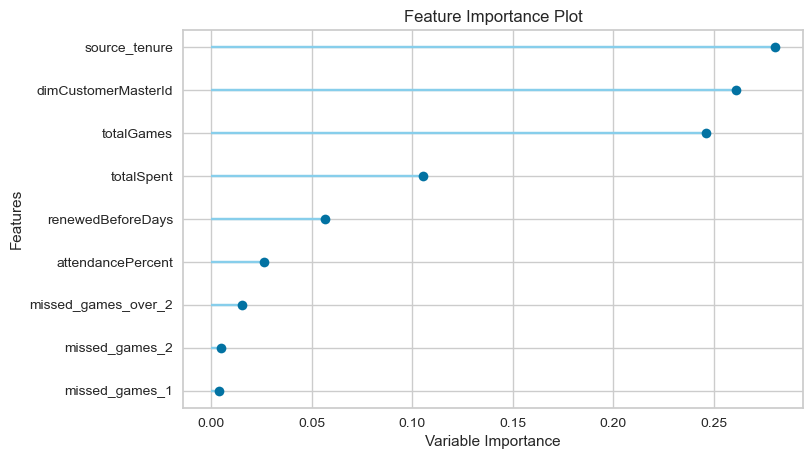

In [13]:
plot_model(best_model, plot='feature')

In [21]:
plot_model(best_model, plot='confusion_matrix')

IntProgress(value=0, description='Processing: ', max=5)

Finished loading model, total used 100 iterations


AttributeError: 'Pipeline' object has no attribute 'fig'

## Conclusions
Here you can talk about next steps, did the experiment work? If yes, what to do next? If no, why?